In [8]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import functools as ftls
from scipy import linalg
import copy
import statistics as st
from matplotlib.pyplot import *
from itertools import combinations

#Create a random regular graph with d degree and n nodes
def new_graph(d, n):
    graph = nx.random_regular_graph(d, n)
    return graph, d, n

#Check if the graphs x and y are isomorphic
def iso_check(x, y):
    isomorphic = nx.is_isomorphic(x, y)
    return isomorphic

#Check if the graph g is connected
def is_connected(g):
    connected = nx.is_connected(g)
    return connected

#Check if graph g is k-regular (same degree k on each node)
def is_k_regular(g, k):
    regular = nx.is_k_regular(g, k)
    return regular

#Generate a set of graphs that are k-regular, connected and non-isomorphic
def generate_graphs(num_edges, num_nodes, num_graphs):
    graph_only =[]
    graph_list = []
    connected_graphs = []
    regular_graphs = []
    if num_edges < 2 and num_nodes < 4:
        graph_only.append(new_graph(num_edges, num_nodes))
        for l in range(len(graph_only)):
            graph_plot = nx.Graph(graph_only[l][0])
            nx.draw(graph_plot, with_labels=True, node_color='blue')
            title = 'Edges %s, Nodes %s Graph %s.png'%(num_edges, num_nodes, l)
            plt.savefig(title)
            plt.show()
        return graph_only
    else:
        for i in range(num_graphs):
            graph_list.append(new_graph(num_edges, num_nodes))
        for i in range(len(graph_list)):
            if (is_k_regular(graph_list[i][0], num_edges)):
                regular_graphs.append(graph_list[i])
        for i in range(len(regular_graphs)):
            if (is_connected(regular_graphs[i][0])):
                connected_graphs.append(regular_graphs[i])
        check = True
        graphs = copy.deepcopy(connected_graphs)
        while (check) and (len(graphs) > 1):
            for i, j in combinations(graphs, 2):
                check = iso_check(i[0], j[0])
                if check:
                    graphs.remove(i)
                    break
        for l in range(len(graphs)):
            graph_plot = nx.Graph(graphs[l][0])
            nx.draw(graph_plot, with_labels=True, node_color='blue')
            title = 'Edges %s, Nodes %s Graph %s.png'%(num_edges, num_nodes, l)
            plt.savefig(title)
            plt.show()
        return graphs

#Initialize Pauli Matrices
def pauli_matrices(n):
    if n == 1:
        s1 = np.array([[0.0, 1.0], [1.0, 0.0]])
        return s1
    if n ==2:
        s2 = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype = 'complex')
        return s2
    if n == 3:
        s3 = np.array([[1.0, 0.0], [0.0, -1.0]])
        return s3

#Generate Problem Hamiltonian for MaxCut
def Hamiltonian_problem(edges, nodes, operator, weighted = False):
    number_of_nodes = len(nodes)
    Hamilt = np.zeros([(2**number_of_nodes), (2**number_of_nodes)], dtype='complex128') #2^#ofQubits x 2^#ofQubits Array filled with zeros
    identity = np.eye((2**number_of_nodes), (2**number_of_nodes), dtype='complex128') #2^#ofQubits x 2^#ofQubits Array with 1's in the diagonal
    if weighted:
        weights = np.random.uniform(low=0.9, high=1.1, size=len(edges))
        weights[np.where(weights > 1.0)[0]] = 1.0
    else:
        weights = np.ones(len(edges)) #Array with size len(edges) filled with ones
    for j, k in zip(edges, weights): #Maxcut
        j = np.sort(j)
        Hamilt += (-1.0) * (identity - (1.0*k*ftls.reduce(np.kron, [np.eye(2**j[0]), (operator), 
            np.eye(2**(j[1]-j[0]-1)),(operator), np.eye(2**(number_of_nodes-j[1]-1))])))/2
    if np.isreal(Hamilt).all():
        Hamilt = Hamilt.real
    return Hamilt, weights

#Generate Driver Hamiltonian for MaxCut and Maxclique
def Hamiltonian_driver(nodes, operator):
    number_of_nodes = len(nodes)
    Hamilt = np.zeros([(2**number_of_nodes), (2**number_of_nodes)], dtype='complex128')
    for j in (nodes):
        Hamilt += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), (operator), np.eye(2**(number_of_nodes-j-1))])
    if np.isreal(Hamilt).all():
        Hamilt = Hamilt.real
    return Hamilt, number_of_nodes

#Calculate the commutator of two matrices
def commutator(hamiltonian_d, hamiltonian_p, anti = False):
    if anti:
        return hamiltonian_d @ hamiltonian_p + hamiltonian_p @ hamiltonian_d
    else:
        return hamiltonian_d @ hamiltonian_p - hamiltonian_p @ hamiltonian_d

#Calculate eigenvalues of a matrix
def eigenvalue(matrix):
    eigenval = np.linalg.eig(matrix)[0]
    return eigenval

#Calculate eigenvectors of a matrix
def eigenvector(matrix):
    eigenvec = np.linalg.eig(matrix)[1]
    return eigenvec

#Calculate the expectation value of a commutator with a given state
def expectation_value(commutator, psi):
    normalized_psi = psi/np.linalg.norm(psi)
    conjugated = np.conj(normalized_psi)
    transversed = conjugated.T
    rho = np.outer(normalized_psi, conjugated)
    expectation2 = np.trace(rho*commutator)
    matrix_mul = (commutator) @ normalized_psi
    expectation = np.inner(transversed, matrix_mul)
    return expectation, expectation2

#Initialize psi
def initial_psi(nodes):
    qubits = len(nodes)
    psi = np.ones(2**qubits, dtype='complex128')/np.sqrt(2**qubits)
    return psi

#Time Evolution Function for the quantum system
def time_evolution(hamiltonian, num_layers, psi_initial, nodes, beta = 0.0, dt = 0.01):
    qubits = len(nodes)
    unitary = np.eye(2**qubits, dtype='complex128')
    beta_list = [beta]
    h_p = hamiltonian[0]
    h_d = hamiltonian[1]
    psi_list = []
    cmtr = commutator(h_d, h_p) #take commutator of hp and hd
    h_p_list = []
    unitary_list = []
    psi = copy.deepcopy(psi_initial)
    psi_list.append(psi)
    for n in range(num_layers):
        psi = linalg.expm(((-1.0j) * 1.0 * h_p * dt)) @ psi
        psi = linalg.expm(((-1.0j) * beta_list[-1] * h_d * dt)) @ psi
        psi_list.append(psi)
        h_p_ev = expectation_value(h_p, psi)[0].real
        h_p_list.append(h_p_ev)
        beta_updt = (-1.0j * expectation_value(cmtr, psi)[0]).real
        beta_list.append(beta_updt)
    return beta_list, psi, unitary, h_p_list, unitary_list, psi_list

#Generate the probability of obtaining the global minimum solution to the original combinatorial optimization problem
def phi(psi, H_p_argmin):
    phi = 0.0
    phi_mean = 0.0
    phi_list = []
    initial_qubit = np.eye(psi[0].shape[0], dtype = 'complex128')
    for x in range(len(psi)):
        psi_x = psi[x]
        phi = 0.0
        qubit = (initial_qubit)
        for i in H_p_argmin:
            phi = phi + (np.absolute(np.vdot(psi_x, qubit[:,i])))**2
            phi_mean = phi_mean + (np.absolute(np.vdot(psi_x, qubit[:,i])))**2
        phi_list.append(phi)
    phi_mean = phi_mean/len(psi)
    return phi_mean, phi_list

#Plot the approximation ratio and the probability of sampling the global optimum as a #function of the number of 
# layers for a single Hamiltonian
def plot_falqon(problem_hamiltonian_expectation_value, h_p, psi_n, H_p_argmin, graph):
    h_p_min = min(np.linalg.eig(h_p)[0])
    r = []
    for i in range(len(problem_hamiltonian_expectation_value)):
        value = (problem_hamiltonian_expectation_value[i])/h_p_min
        r.append(value)
    print('Approximation mean ratio:\n', st.mean(r))
    plt.plot(r, label='approximation ratio')
    plt.axhline(y=0.93, color='black',linestyle='--')
    plt.grid(visible=True, which='major',axis='both')
    plt.xlabel("Layers")
    phi_number = phi(psi_n, H_p_argmin)
    print('Mean phi value = ', phi_number[0])
    plt.axhline(y=0.25, color='black', linestyle='-')
    plt.plot(phi_number[1], label='Probability of sampling global optimum')
    plt.title('Performance of FALQON for %s -regular graph with %s vertices.'%(graph[1], graph[2]))
    plt.legend(fontsize='medium', loc = 4)
    plt.show()

#Plot the beta values at each layer
def plot_Beta(beta_list_original):
    abs_beta = []
    for i in range(len(beta_list_original)):
        abs_beta.append(-1.0*(beta_list_original[i]))
    plt.plot(abs_beta,label='beta')
    plt.legend(fontsize='medium', loc = 1) #Shows the lenged 
    plt.grid(visible=True, which='major', axis='both')
    plt.xlabel("Layers")
    plt.ylabel(r'$\beta$')
    plt.show()

def execute_FALQON(list_graphs, layers, beta, dt):
    h_p_values = []
    psi_values = []
    H_p_argmin_values = []
    Hamiltonian_problem_list = []
    Hamiltonian_driver_list = []
    graphs_array = []
    beta_values = []
    graph_for_FALQON =[]
    for g in range(len(list_graphs)):
        graph_for_FALQON = list_graphs[g]
        z = pauli_matrices(3)
        H_p = Hamiltonian_problem(graph_for_FALQON[0].edges, graph_for_FALQON[0].nodes, z, weighted = False) #Maxcut
        x = pauli_matrices(1)
        H_d = Hamiltonian_driver(graph_for_FALQON[0].nodes,  x)
        psi_initial = initial_psi(graph_for_FALQON[0].nodes)
        hamiltonian_preparation = []*2
        hamiltonian_preparation.append(H_p[0])
        hamiltonian_preparation.append(H_d[0])
        test_time_evolution = time_evolution(hamiltonian_preparation, layers, psi_initial, graph_for_FALQON[0].nodes, beta, dt)
        H_p_argmin = np.where((np.diag(H_p[0])-np.diag(H_p[0])[np.argmin(np.diag(H_p[0]))])<=1e-10)[0]
        h_p_values.append(test_time_evolution[3])
        psi_values.append(test_time_evolution[5])
        H_p_argmin_values.append(H_p_argmin)
        Hamiltonian_problem_list.append(H_p[0])
        Hamiltonian_driver_list.append(H_d[0])
        graphs_array.append(graph_for_FALQON)
        plot_falqon(test_time_evolution[3], H_p[0], test_time_evolution[5], H_p_argmin, graph_for_FALQON)
        beta_list_original = test_time_evolution[0]
        beta_values.append(beta_list_original)
        plot_Beta(beta_values[g])
    return h_p_values, Hamiltonian_problem_list, psi_values, H_p_argmin_values, graphs_array, beta_values, Hamiltonian_driver_list

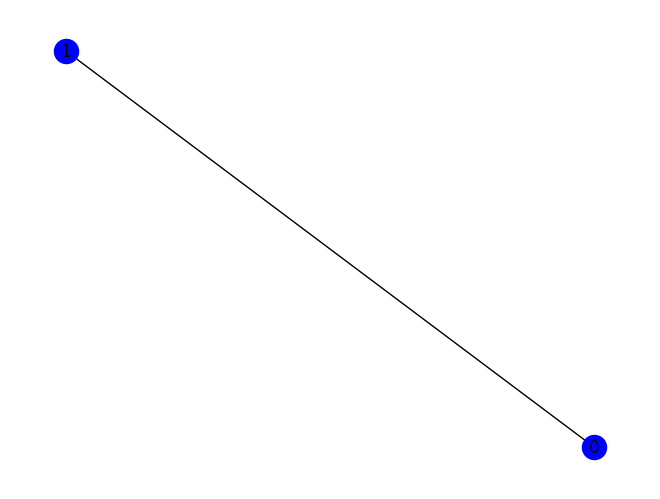

Approximation mean ratio:
 0.9312975426266322
0.9295792257237309
Mean phi value =  0.9295792257237309


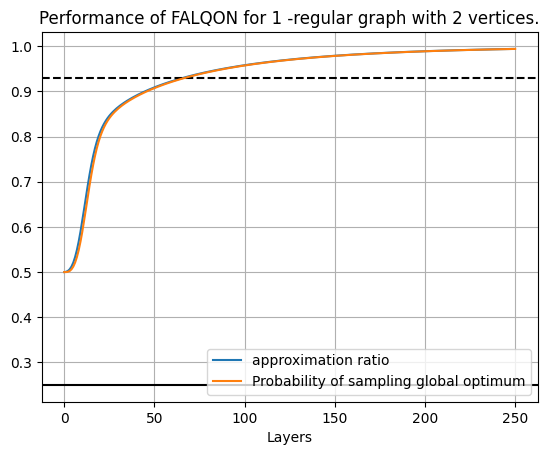

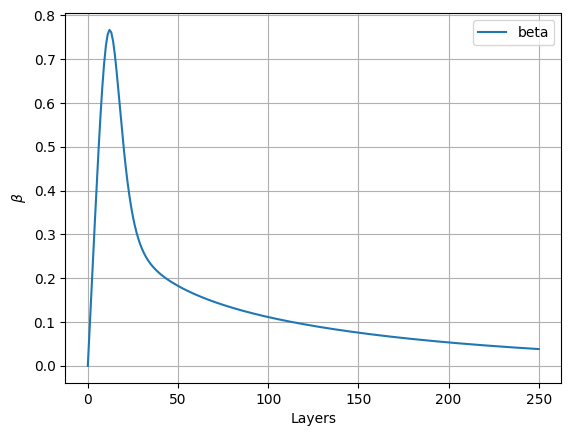

In [9]:
list_of_graphs_for_FALQON = generate_graphs(1, 2, 10)
list_plots_FALQON = execute_FALQON(list_of_graphs_for_FALQON, 250, 0.0, 0.0425)